In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'


import warnings
warnings.filterwarnings('ignore')


# Croatian Verb Categorization

authors: Rebeka Čorić, Domagoj Ševerdija, Lucian Šošić

## Problem definition

In this paper we present croatian verb classification from infinitive form to present form and vice-versa. In both cases convolutional Neural Network is employed to learn a classifer.

## Model evaluation

Our models are evaluated in terms of accuracy, micro-  and macro-averages of F1 scores together with weigthed $F_1$ score.

## Problem 1: Infinitive stem classification

In [13]:
from inf2pres.utils         import loadData, class_present

### Dataset

Dataset consists of pairs $(w_{inf},C_{pres})$ where $w_{inf}$ denotes infinitive form of verb $w$ and $C_{pres}\in \{-am,-im,-jem,-em\}$ as a class denoted with respect to 1st person present suffix.


In [14]:
train_set, val_set, test_set, all_categories = loadData('inf2pres/data/')
train_set[:5], all_categories[:5]

([['nasukati', 0],
  ['izdeklamirati', 0],
  ['nahvatati', 0],
  ['sazrijevati', 0],
  ['tupkati', 0]],
 [0, 1, 2, 3])

In [15]:
import pandas as pd
pd.set_option("display.precision", 2)


train_df = pd.DataFrame(train_set,columns=['word','class'])
val_df   = pd.DataFrame(val_set,columns=['word','class'])
test_df  = pd.DataFrame(test_set,columns=['word','class'])


stats = pd.DataFrame(data = 
                     {'classes' : class_present.values(), 
                      'train' : train_df['class'].value_counts(sort=False), 
                      'val' : val_df['class'].value_counts(sort=False),
                      'test' : test_df['class'].value_counts(sort=False)},                                          
                      
        ).set_index('classes')

        
stats.loc['total']= stats.sum(numeric_only=True, axis=0)
stats.loc[:,'total']= stats.sum(numeric_only=True, axis=1)

idx= ['train','val','test','total']

df = stats.copy()
stats[idx] = stats[idx].apply(lambda x: x / x['total'] * 100, axis=0)

stats[idx]['total'] 
for c in idx : stats[c]['total'] = df[c]['total'] / df['total']['total'] * 100

print(stats.to_latex(index=True))

stats

\begin{tabular}{lrrrr}
\toprule
{} &  train &    val &   test &   total \\
classes &        &        &        &         \\
\midrule
am      &  36.04 &  35.96 &  35.95 &   36.02 \\
im      &  34.79 &  34.81 &  34.76 &   34.79 \\
jem     &  11.32 &  11.33 &  11.39 &   11.33 \\
em      &  17.85 &  17.90 &  17.90 &   17.86 \\
total   &  80.95 &   9.03 &  10.02 &  100.00 \\
\bottomrule
\end{tabular}



,train,val,test,total
classes,,,,
am,36.04,35.96,35.95,36.02
im,34.79,34.81,34.76,34.79
jem,11.32,11.33,11.39,11.33
em,17.85,17.90,17.90,17.86
total,80.95,9.03,10.02,100.00


### Rule-based model: SSF parser


In [13]:
from inf2pres.utils import loadData
import numpy as np

train_ssf, val_ssf, test_ssf, all_categories = loadData('inf2pres/data/',prefix='ssf_glagoli')
test_ssf[:5]

[['iscrtati', 0],
 ['šikljati', 0],
 ['izredati', -1],
 ['ojačati', -1],
 ['vulgarizirati', 0]]

In [14]:
test_set[:5]

[['iscrtati', 0],
 ['šikljati', 0],
 ['izredati', 0],
 ['ojačati', 0],
 ['vulgarizirati', 0]]

In [15]:
# predictions and gold standard
pred = np.array(test_ssf)[:,1].astype(int)
gold = np.array(test_set)[:,1].astype(int)

In [20]:
# -1 is not of any know class, by default choose 0
pred = np.where(pred==-1, 0, pred)


In [21]:
# data checking

# read gold standard
df_ssf = pd.DataFrame(test_set,columns =  ['verb','gold'])
df_ssf['predicted'] = pred

# originalni podaci
df_ssf

# class 0 correct
df_ssf[(df_ssf['gold'] == 0) & (df_ssf['predicted'] == -1) ]

#total_am = df_ssf[(df_ssf['gold'] == 0)]['verb'].count()
total_predicted = df_ssf.groupby('predicted')['verb'].count()

total_gold = df_ssf.groupby('gold')['verb'].count()
                  
total_predicted

total_gold




gold
0    243
1    235
2     77
3    121
Name: verb, dtype: int64

 --------------Evaluation metrics: ---------------------- 
        * test accuracy: 0.667, 
        * test rmse: 0.047,
        * test micro-F1: 0.667,
        * test macro-F1: 0.635,
        * test weighted-F1: 0.658
    


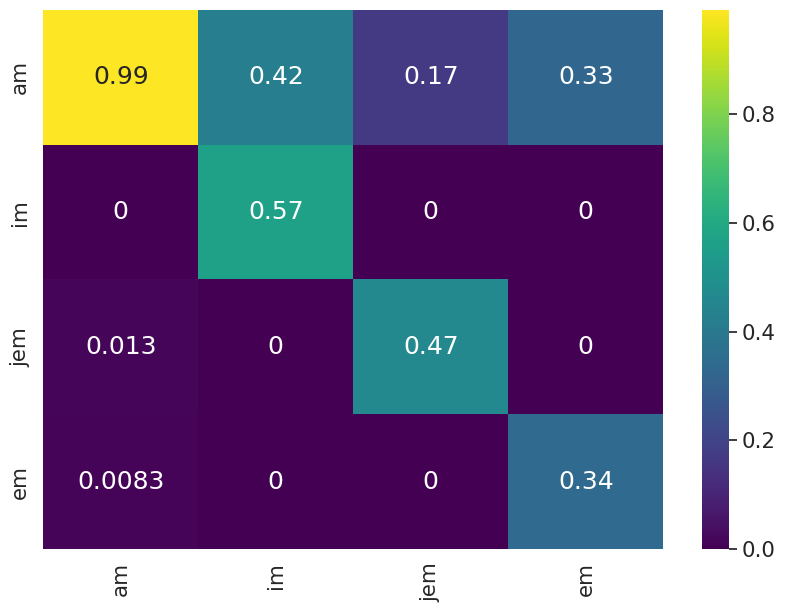

In [22]:
# metrics

# confusion matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error, f1_score

# suffix mappings
from inf2pres.utils import suffixes


# total
total = len(pred)

correct = (pred == gold).sum()

# num of good predictions
correct

# accuracy
accuracy = correct/total
# rmse
rmse = np.sqrt(mean_squared_error(pred, gold)*total)/total

# micro-F1
micro_f1 = f1_score(gold, pred, average='micro')
macro_f1 = f1_score(gold, pred, average='macro')

# weighted F1
weighted_f1 = f1_score(gold, pred, average='weighted')



output =  f""" --------------Evaluation metrics: ---------------------- 
        * test accuracy: {accuracy:.3f}, 
        * test rmse: {rmse:.3f},
        * test micro-F1: {micro_f1:.3f},
        * test macro-F1: {macro_f1:.3f},
        * test weighted-F1: {weighted_f1:.3f}
    """


print(output)



# confusion matrix
all_categories = np.array(all_categories)
pred_categories = all_categories[all_categories > -1]
size = pred_categories.shape[0]


confusion = np.zeros((size, size))  

for i in range(len(pred)):
        confusion[pred[i]][gold[i]] += 1.0
        

# Normalizacija dijeljenjem svakog retka sumom tog retka.
for i in range(size):
    confusion[i] = confusion[i] / total_gold[i]


# Definiranje prikaza matrice zbunjenosti   
#size = len(suffixes)    
df_cm = pd.DataFrame(confusion, range(size), range(size))
fig = plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm,cmap="viridis", annot=True, annot_kws={"size": 18}) # font size

# Postavljanje osi    
_ = ax.set_xticklabels( suffixes, rotation=90)
_ = ax.set_yticklabels(suffixes)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


### Ablation study

#### FF model

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.409
 * test accuracy: 0.859,
 * test rmse: 0.881,
 * test microF1: 0.835,
 * test macroF1: 0.859,
 * test weightedF1: 0.859


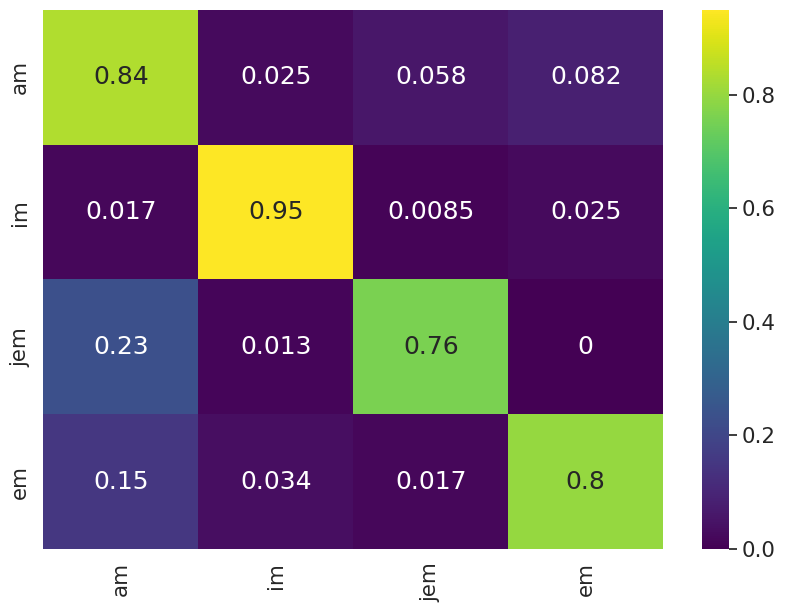

In [16]:
from inf2pres.evaluateFF import evaluateOnTestSet, loadModel, heatmap, predict, probabilities

# load categories
from inf2pres.utils import loadData
import numpy as np

_,_, test_set, all_categories = loadData('inf2pres/data/',prefix='glagoli')


# evaluacija prethodno spremljenog modela
model_weights_path = 'inf2pres/models/baseline.weights'
model = loadModel(model_weights_path)
evaluateOnTestSet(model, test_set,all_categories)

#### FF model with windows

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.341
 * test accuracy: 0.885,
 * test rmse: 0.781,
 * test microF1: 0.863,
 * test macroF1: 0.885,
 * test weightedF1: 0.884


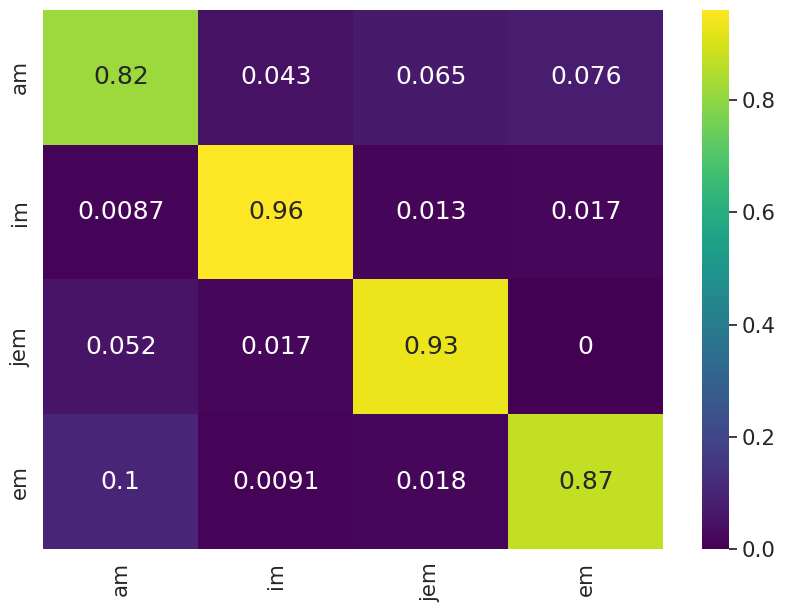

In [13]:
from inf2pres.evaluateFF import evaluateOnTestSet, loadModel_withWindow, heatmap, predict, probabilities


# load categories
from inf2pres.utils import loadData
import numpy as np

_,_, test_set, all_categories = loadData('inf2pres/data/',prefix='glagoli')


# evaluacija prethodno spremljenog modela
model_weights_path = 'inf2pres/models/baseline+window.weights'
model = loadModel_withWindow(model_weights_path)
evaluateOnTestSet(model, test_set,all_categories)

#### CNN model with 1 convolution

[0, 1, 2, 3]
 --------------Evaluation metrics: ----------------------           
 * test loss: 0.167
 * test accuracy: 0.939,
 * test rmse: 0.565,
 * test microF1: 0.939,
 * test macroF1: 0.928,
 * test weightedF1: 0.939


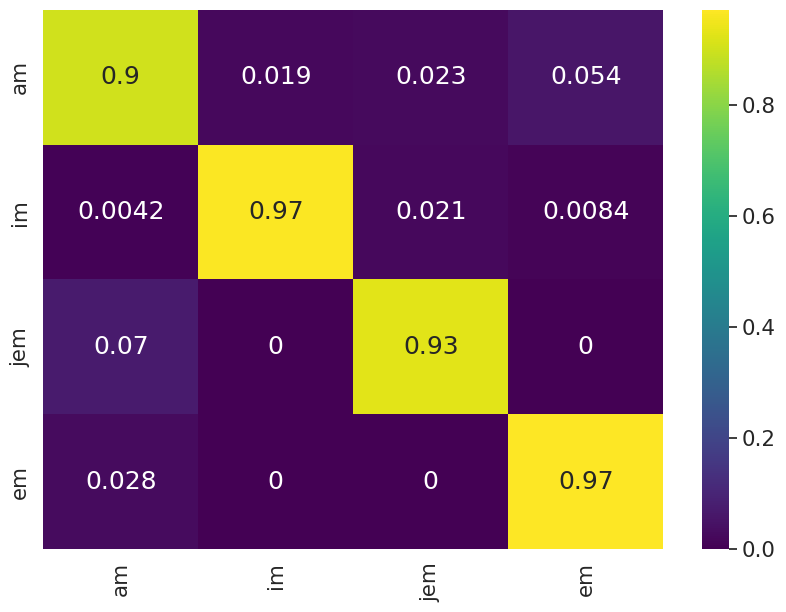

In [14]:
from inf2pres.evaluate import loadModel
from inf2pres.evaluate import cnn_1_params

from inf2pres.evaluate import evaluateOnTestSet, loadModel, heatmap, predict, probabilities

# load test set
_,_, test_set, all_categories = loadData('inf2pres/data/',prefix='glagoli')

# evaluacija prethodno spremljenog modela
model_weights_path = 'inf2pres/models/cnn_1filter.weights'
model = loadModel(model_weights_path,params = cnn_1_params)

print(all_categories)
evaluateOnTestSet(model, test_set,all_categories)


#### CNN model with 5 convolutions

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.173
 * test accuracy: 0.941,
 * test rmse: 0.534,
 * test microF1: 0.941,
 * test macroF1: 0.927,
 * test weightedF1: 0.940


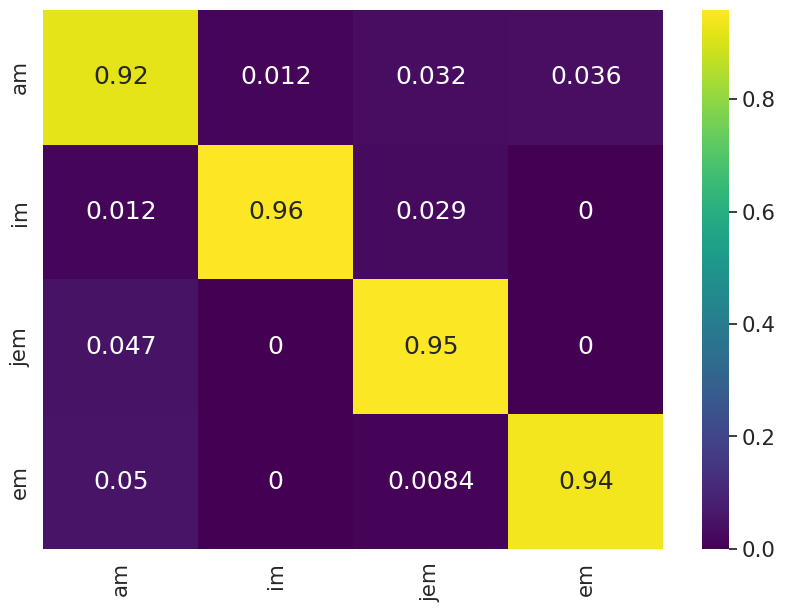

In [15]:
from inf2pres.evaluate import loadModel
from inf2pres.evaluate import cnn_4_params

from inf2pres.evaluate import evaluateOnTestSet, loadModel, heatmap, predict, probabilities



# load test set
_,_, test_set, all_categories = loadData('inf2pres/data/',prefix='glagoli')

# evaluacija prethodno spremljenog modela
model_weights_path = 'inf2pres/models/cnn.weights'
model = loadModel(model_weights_path,params = cnn_4_params)
evaluateOnTestSet(model, test_set,all_categories)


 --------------Evaluation metrics: ----------------------           
 * test loss: 0.165
 * test accuracy: 0.947,
 * test rmse: 0.469,
 * test microF1: 0.947,
 * test macroF1: 0.936,
 * test weightedF1: 0.947


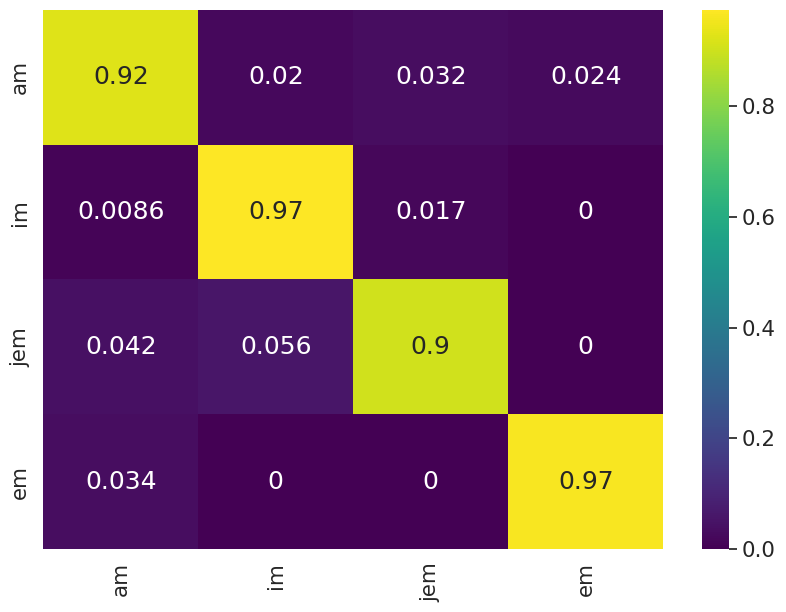

In [17]:
# with dropout
from inf2pres.evaluate import loadModel
from inf2pres.evaluate import cnn_4_params

from inf2pres.evaluate import evaluateOnTestSet, loadModel, heatmap, predict, probabilities



# load test set
_,_, test_set, all_categories = loadData('inf2pres/data/',prefix='glagoli')

# evaluacija prethodno spremljenog modela
model_weights_path = 'inf2pres/models/cnn+dropout.weights'
model = loadModel(model_weights_path,params = cnn_4_params)
evaluateOnTestSet(model, test_set,all_categories)

## Model testing

Some interesting examples with an interpretation.

In [16]:
%%writefile inf2pres.input
glumovati
čarkati
čamiti
čupati
čarnuti
ispuznuti
zagrnuti
zagrliti
poodmaći
potpasti
preplesti
prostrti

Overwriting inf2pres.input


In [17]:
from inf2pres.evaluate import loadModel
from inf2pres.evaluate import cnn_4_params


# load best model
model_weights_path = 'inf2pres/models/cnn+dropout.weights'
model = loadModel(model_weights_path,params = cnn_4_params)

INF2PRES class: jem


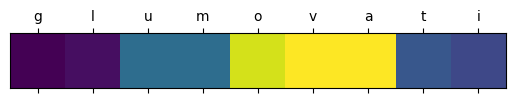

INF2PRES class: am


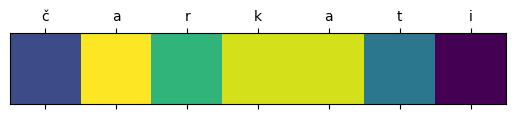

INF2PRES class: im


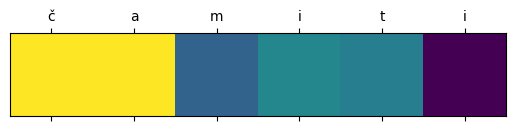

INF2PRES class: am


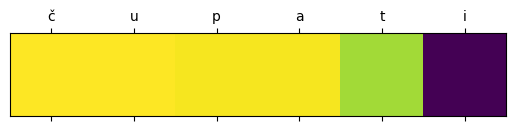

INF2PRES class: em


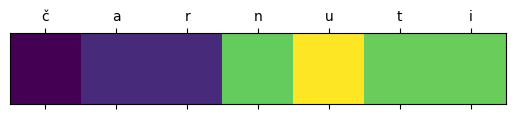

INF2PRES class: em


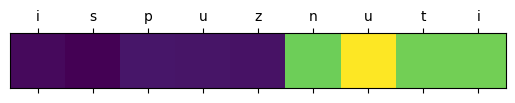

INF2PRES class: em


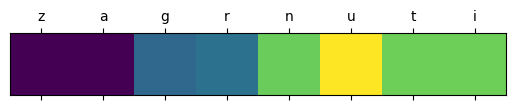

INF2PRES class: im


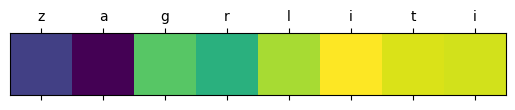

INF2PRES class: em


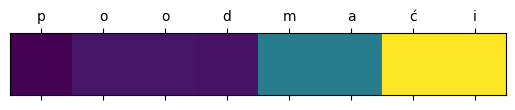

INF2PRES class: em


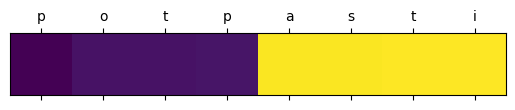

INF2PRES class: em


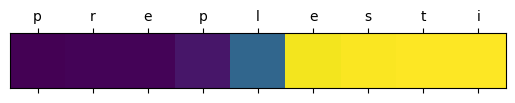

INF2PRES class: em


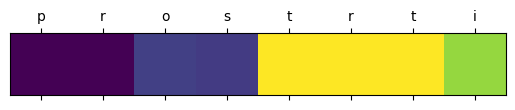

In [18]:
from inf2pres.evaluate import heatmap

with open('inf2pres.input') as f:
    glagoli = f.read().splitlines()
    
#napravi heatmap
_ = [heatmap(model,verb) for verb in glagoli ]

In [20]:
for glagol in glagoli:
    prob = probabilities(model,glagol)
    print(f'{glagol}:   \t{prob}')

glumovati:   	{'jem': 0.49, 'am': 0.315, 'im': 0.195, 'em': 0.0}
čarkati:   	{'am': 0.467, 'em': 0.312, 'im': 0.221, 'jem': 0.0}
čamiti:   	{'im': 0.555, 'jem': 0.248, 'am': 0.197, 'em': 0.0}
čupati:   	{'am': 0.6, 'im': 0.323, 'em': 0.077, 'jem': 0.0}
čarnuti:   	{'em': 0.612, 'im': 0.22, 'am': 0.168, 'jem': 0.0}
ispuznuti:   	{'em': 0.893, 'im': 0.096, 'jem': 0.01, 'am': 0.0}
zagrnuti:   	{'em': 0.711, 'im': 0.184, 'am': 0.105, 'jem': 0.0}
zagrliti:   	{'im': 0.602, 'jem': 0.312, 'em': 0.085, 'am': 0.0}
poodmaći:   	{'em': 0.638, 'am': 0.293, 'jem': 0.069, 'im': 0.0}
potpasti:   	{'em': 0.82, 'am': 0.119, 'jem': 0.061, 'im': 0.0}
preplesti:   	{'em': 0.751, 'am': 0.181, 'im': 0.068, 'jem': 0.0}
prostrti:   	{'em': 0.628, 'im': 0.234, 'am': 0.138, 'jem': 0.0}


## Application of classificator

Testing `šetati`

INF2PRES class: am


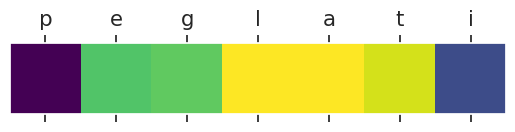

INF2PRES class: jem


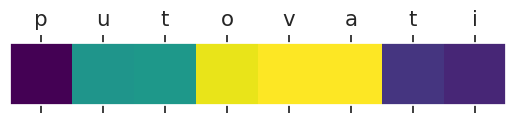

In [21]:
glagol = 'peglati'
heatmap(model,glagol)

glagol = 'putovati'
heatmap(model,glagol)



### All gathered verbs

In [37]:
# take all verbs and classify them ...
with open('dataset/svi_glagoli.txt','r') as f:
    glagoli = f.read().split()
    
glagoli[:5]


['abadati', 'abandonirati', 'abdicirati', 'abecedirati', 'aberirati']

In [38]:
prezent_klase = {v: k for k, v in class_present.items()}

print(prezent_klase)
    
glagoli_data = [[glagol,prezent_klase[predict(model,glagol)]] for glagol in glagoli ]


#glagoli_data
glagoli_df  = pd.DataFrame(glagoli_data,columns=['word','class'])
glagoli_df
#train_df

{'am': 0, 'im': 1, 'jem': 2, 'em': 3}


,word,class
0,abadati,0
1,abandonirati,0
2,abdicirati,0
3,abecedirati,0
4,aberirati,0
...,...,...
18346,žveglati,0
18347,žveplati,0
18348,žvepliti,1
18349,žvignuti,3


In [33]:

stats = pd.DataFrame(data = 
                     {'classes' : class_present.values(),                       
                      'glagoli' : glagoli_df['class'].value_counts(sort=False)}                                         
                      
        ).set_index('classes')


stats.loc['total']= stats.sum(numeric_only=True, axis=0)
#stats.loc[:,'total']= stats.sum(numeric_only=True, axis=1)

#idx= ['glagoli','total']
idx= ['glagoli']

df = stats.copy()
stats[idx] = stats[idx].apply(lambda x: x / x['total'] * 100, axis=0)

#stats[idx]['total'] 
#for c in idx : stats[c]['total'] = df[c]['total'] / df['total']['total'] * 100

print(stats.to_latex(index=True))

stats.to_csv('dataset/inf2pres_all.csv')

stats



\begin{tabular}{lr}
\toprule
{} &  glagoli \\
classes &          \\
\midrule
am      &    40.07 \\
im      &    28.09 \\
jem     &    18.34 \\
em      &    13.50 \\
total   &   100.00 \\
\bottomrule
\end{tabular}



,glagoli
classes,
am,40.07
im,28.09
jem,18.34
em,13.50
total,100.00


In [35]:
# output all verbs with its present stems
with open('dataset/inf2pres_all.txt','w') as f:
    for glagol in glagoli:
        f.write(f'{glagol}:{predict(model,glagol)}\n')
        

## Problem 2: Present stem classification

In [7]:
import pres2inf
#from pres2inf.evaluate import evaluateOnTestSet, loadModel, heatmap, predict, probabilities
from pres2inf.utils    import loadData, class_infinitive

class_infinitive

{0: 'ati',
 1: 'iti',
 2: 'jeti',
 3: 'eti',
 4: 'uti',
 5: 'sti',
 6: 'rti',
 7: 'ći'}

### Dataset

Dataset consists of pairs $(w_{inf},C_{pres})$ where $w_{inf}$ denotes infinitive form of verb $w$ and $C_{pres}\in \{-ati,-iti,-eti,-jeti,-uti,-rti,-sti,-ći\}$ as a class denoted with respect to 1st person present suffix.

In [8]:
# dataset
train_set, val_set, test_set, all_categories = loadData('pres2inf/data/')

In [3]:
import pandas as pd
train_df = pd.DataFrame(train_set,columns=['word','class'])
val_df   = pd.DataFrame(val_set,columns=['word','class'])
test_df  = pd.DataFrame(test_set,columns=['word','class'])



stats = pd.DataFrame(data = 
                     {'classes' : class_infinitive.values(), 
                      'train' : train_df['class'].value_counts(sort=False), 
                      'val' : val_df['class'].value_counts(sort=False),
                      'test' : test_df['class'].value_counts(sort=False)},                                          
                      
        ).set_index('classes')


        
stats.loc['total']= stats.sum(numeric_only=True, axis=0).astype(int)
stats.loc[:,'total']= stats.sum(numeric_only=True, axis=1).astype(int)

idx= ['train','val','test','total']

df = stats.copy()
stats[idx] = stats[idx].apply(lambda x: x / x['total'] * 100, axis=0)

stats[idx]['total'] 
for c in idx : stats[c]['total'] = df[c]['total'] / df['total']['total'] * 100

print(stats.to_latex(index=True))

stats



\begin{tabular}{lrrrr}
\toprule
{} &      train &        val &       test &       total \\
classes &            &            &            &             \\
\midrule
ati     &  53.782744 &  53.594771 &  53.382353 &   53.725374 \\
iti     &  32.093790 &  31.862745 &  31.911765 &   32.054510 \\
jeti    &   3.333944 &   3.431373 &   3.382353 &    3.347652 \\
eti     &   0.604506 &   0.653595 &   0.735294 &    0.622130 \\
uti     &   6.081700 &   6.045752 &   6.176471 &    6.087987 \\
sti     &   2.088295 &   2.124183 &   2.205882 &    2.103392 \\
rti     &   0.164865 &   0.326797 &   0.294118 &    0.192564 \\
ći      &   1.850156 &   1.960784 &   1.911765 &    1.866390 \\
total   &  80.862095 &   9.065324 &  10.072582 &  100.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_75736/229557285.py:29: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=True))


,train,val,test,total
classes,,,,
ati,53.782744,53.594771,53.382353,53.725374
iti,32.093790,31.862745,31.911765,32.054510
jeti,3.333944,3.431373,3.382353,3.347652
eti,0.604506,0.653595,0.735294,0.622130
uti,6.081700,6.045752,6.176471,6.087987
sti,2.088295,2.124183,2.205882,2.103392
rti,0.164865,0.326797,0.294118,0.192564
ći,1.850156,1.960784,1.911765,1.866390
total,80.862095,9.065324,10.072582,100.000000


### Rule-based model: SSF parser


In [4]:
from pres2inf.utils import loadData
import numpy as np

train_ssf, val_ssf, test_ssf, all_categories = loadData('pres2inf/data/',prefix='ssf_glagoli')
test_ssf[:5]

[['iscrtam', 0],
 ['šikljam', 0],
 ['izredah', 0],
 ['ojačah', 0],
 ['vulgariziram', 0]]

### Ablation study

#### FF model

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.336
 * test accuracy: 0.894,
 * test rmse: 1.016,
 * test microF1: 0.643,
 * test macroF1: 0.894,
 * test weightedF1: 0.879


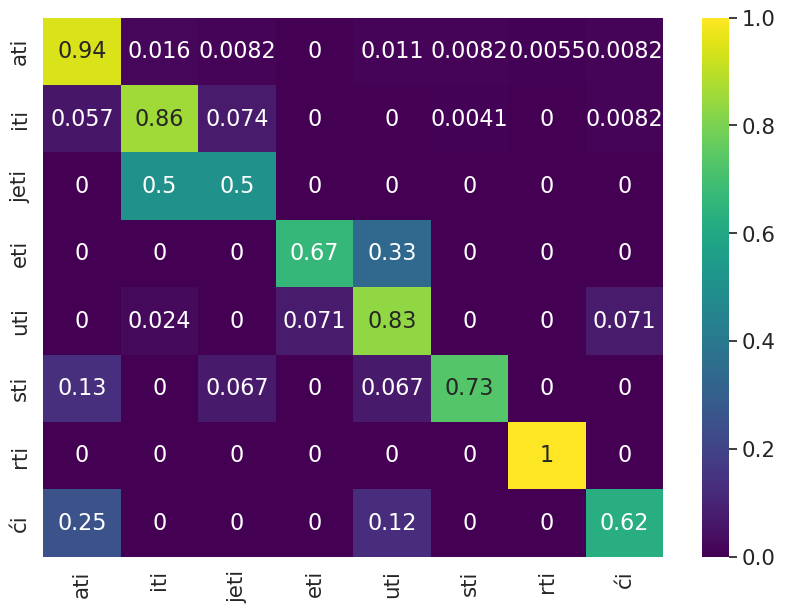

In [21]:
from pres2inf.evaluateFF import evaluateOnTestSet, loadModel, heatmap, predict, probabilities

# evaluacija prethodno spremljenog modela
model_weights_path = 'pres2inf/models/baseline.weights'
model = loadModel(model_weights_path)
evaluateOnTestSet(model, test_set,all_categories)

#### FF model with windows

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.266
 * test accuracy: 0.913,
 * test rmse: 0.773,
 * test microF1: 0.703,
 * test macroF1: 0.913,
 * test weightedF1: 0.907


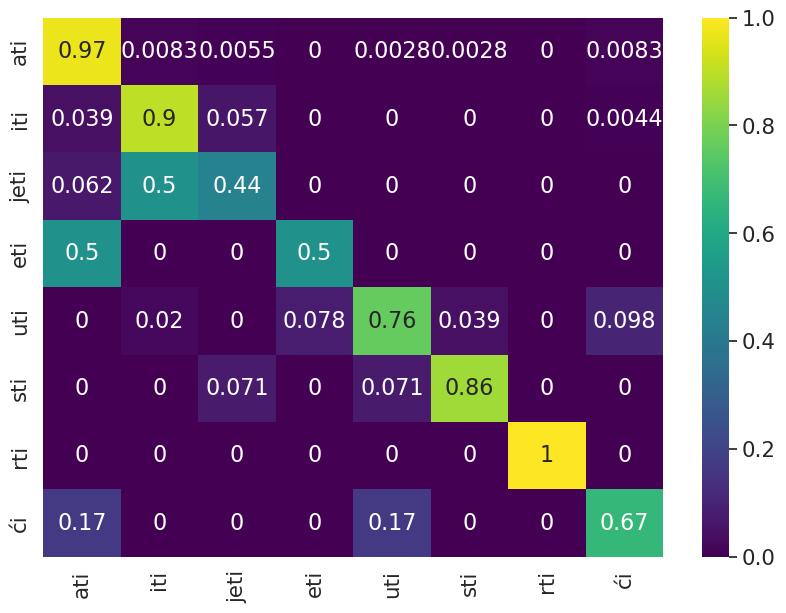

In [37]:
from pres2inf.evaluateFF import evaluateOnTestSet, loadModel_withWindow, heatmap, predict, probabilities


# load categories
from inf2pres.utils import loadData
import numpy as np

_,_, test_set, all_categories = loadData('pres2inf/data/',prefix='glagoli')


# evaluacija prethodno spremljenog modela
model_weights_path = 'pres2inf/models/baseline+window.weights'
model = loadModel_withWindow(model_weights_path)
evaluateOnTestSet(model, test_set,all_categories)

#### CNN model with 1 filter

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.193
 * test accuracy: 0.946,
 * test rmse: 0.529,
 * test microF1: 0.946,
 * test macroF1: 0.783,
 * test weightedF1: 0.943


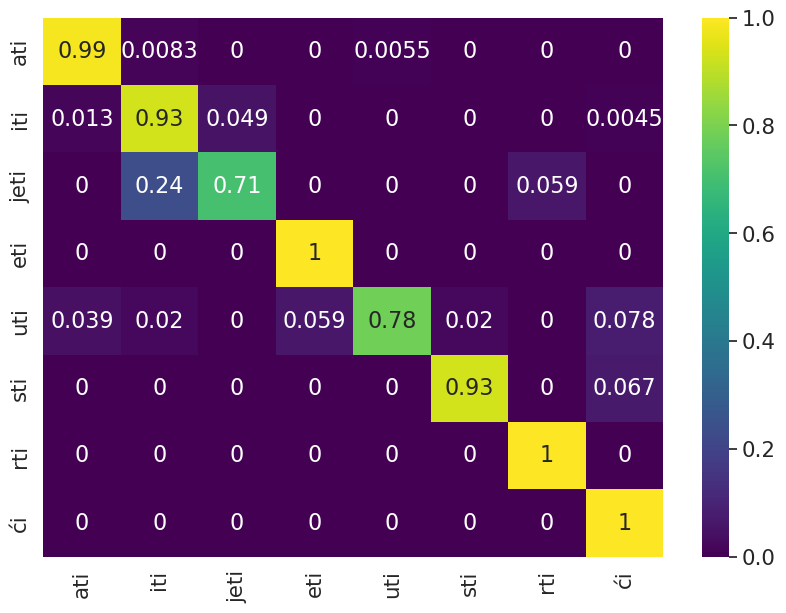

In [38]:
from pres2inf.evaluate import evaluateOnTestSet, loadModel, heatmap, predict, probabilities
from pres2inf.evaluate import cnn_1_params

# evaluacija prethodno spremljenog modela
model_weights_path = 'pres2inf/models/cnn_1filter.weights'
model = loadModel(model_weights_path, params = cnn_1_params)
evaluateOnTestSet(model, test_set,all_categories)

#### CNN model with 5 filters

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.188
 * test accuracy: 0.950,
 * test rmse: 0.467,
 * test microF1: 0.950,
 * test macroF1: 0.835,
 * test weightedF1: 0.948


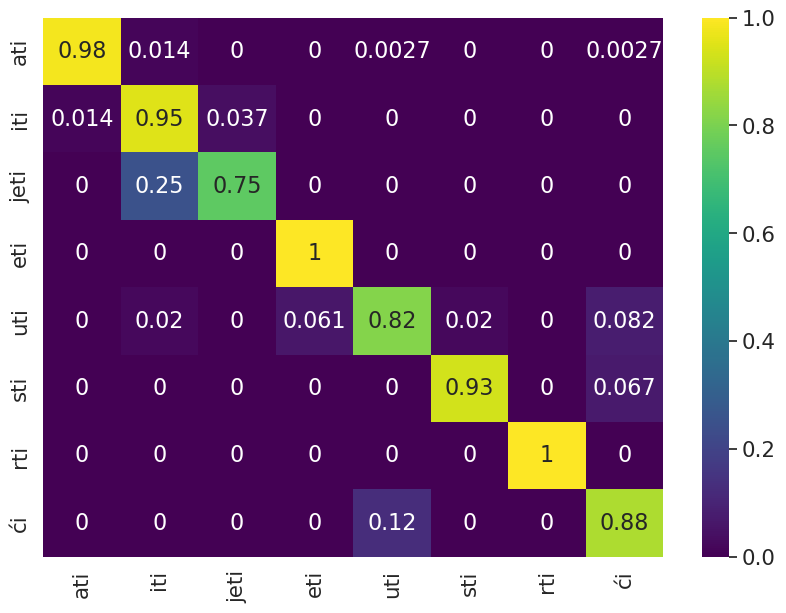

In [28]:
from pres2inf.evaluate import evaluateOnTestSet, loadModel, heatmap, predict, probabilities
from pres2inf.evaluate import cnn_4_params

# evaluacija prethodno spremljenog modela
model_weights_path = 'pres2inf/models/cnn.weights'
model = loadModel(model_weights_path, params = cnn_4_params)
evaluateOnTestSet(model, test_set,all_categories)

 --------------Evaluation metrics: ----------------------           
 * test loss: 0.165
 * test accuracy: 0.947,
 * test rmse: 0.520,
 * test microF1: 0.947,
 * test macroF1: 0.834,
 * test weightedF1: 0.943


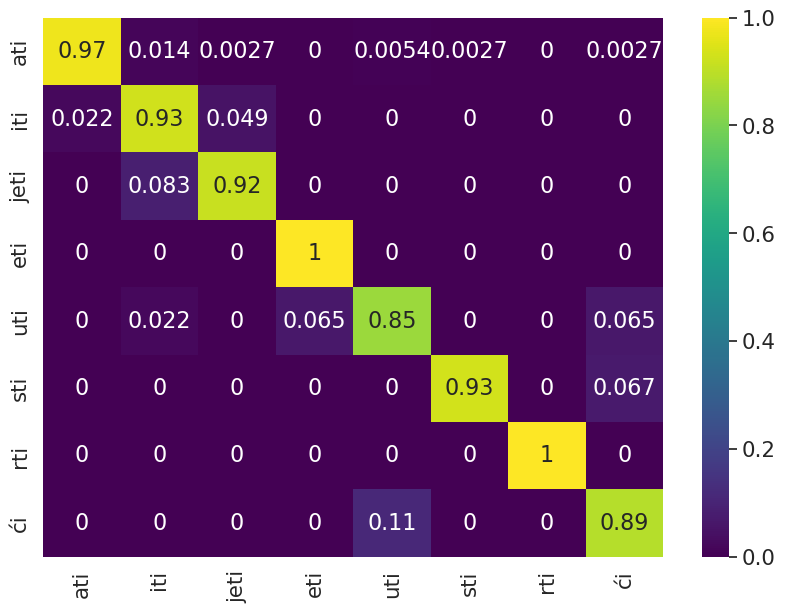

In [29]:
# with dropout
from pres2inf.evaluate import evaluateOnTestSet, loadModel, heatmap, predict, probabilities
from pres2inf.evaluate import cnn_4_params

# evaluacija prethodno spremljenog modela
model_weights_path = 'pres2inf/models/cnn+dropout.weights'
model = loadModel(model_weights_path, params = cnn_4_params)
evaluateOnTestSet(model, test_set,all_categories)

## Model testing

In [9]:
%%writefile pres2inf.input
glumim
čarkam
čamim
čupam
čarnem
ispuznem
zagrnem
zagrlim
poodmaknem
potpadnem
prepletem
prostrem

Overwriting pres2inf.input


PRES2INF class: iti


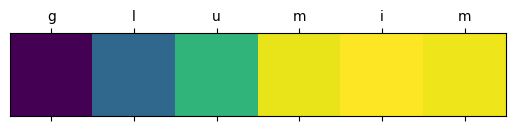

PRES2INF class: ati


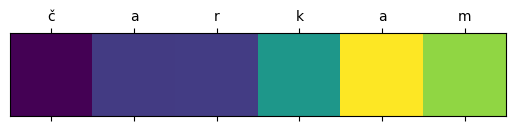

PRES2INF class: iti


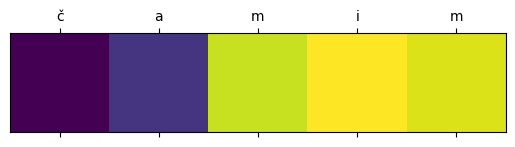

PRES2INF class: ati


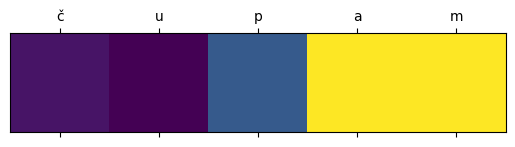

PRES2INF class: uti


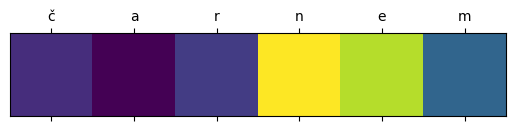

PRES2INF class: uti


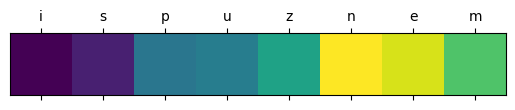

PRES2INF class: uti


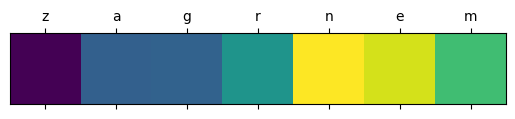

PRES2INF class: iti


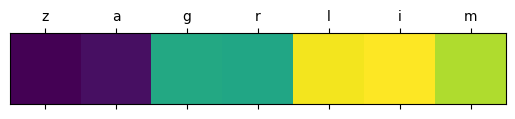

PRES2INF class: uti


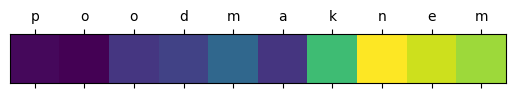

PRES2INF class: sti


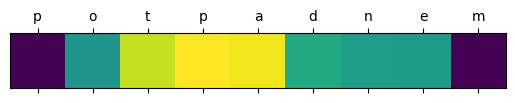

PRES2INF class: sti


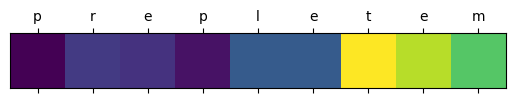

PRES2INF class: rti


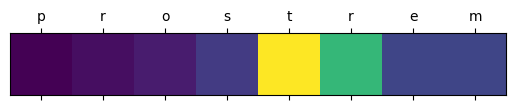

In [11]:
# with dropout
from pres2inf.evaluate import loadModel, heatmap
from pres2inf.evaluate import cnn_4_params

# evaluacija prethodno spremljenog modela
model_weights_path = 'pres2inf/models/cnn+dropout.weights'
model = loadModel(model_weights_path, params = cnn_4_params)


with open('pres2inf.input') as f:
    glagoli = f.read().splitlines()
    

#napravi heatmap
_ = [heatmap(verb,model) for verb in glagoli ]

In [32]:
prob = probabilities(model,glagoli[0])
for glagol in glagoli:
    print(f'{glagol}: \t{prob}')

glumovati: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
čarkati: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
čamiti: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
čupati: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
čarnuti: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
ispuznuti: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
zagrnuti: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
zagrliti: 	{'ati': 0.233, 'iti': 0.201, 'jeti': 0.161, 'rti': 0.129, 'sti': 0.118, 'uti': 0.091, 'ći': 0.067, 'eti': 0.0}
poodmaći: 	{'ati': 0.233, 'i

## Converting files